# 1.1 (a) & (b)

  Evaluated 50 individuals
The fitness of the fittest individual is 0.6806963770148338
Decoded values of x1, x2 is 0.08965861983597279, -0.7478875946253538


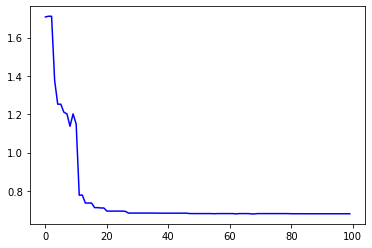

In [1]:
# Referenced from Week 2 material provided Dr. Frank Guerin

import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 50 #Population size
dimension   = 2 #Number of decision variable x 
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .1 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....


toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
# fitness function: 
#
# f(x1,x2) = 2 + (4.1 * x1^2) - (2.1 * x1^4) + (1/3 * x1^6) + (x1*x2) - (4 * (x2 - 0.05)^2) + (4 * x2^4)
def my_func(individual):
    sep=separatevariables(individual)
    f = 2 + (4.1 * sep[0]**2) - (2.1 * sep[0]**4) + (1/3 * sep[0]**6) + (sep[0] * sep[1]) - (4 * (sep[1] - 0.05)**2) + (4 * sep[1]**4) 
    return 1.0/(0.01+f), # DEAP doesn't allow minimisation for roulette selection
                         # so we convert to maximisation
#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", my_func)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: This uses fitness proportionate selection,
# also known as roulette wheel selection
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-5+10*numasint/maxnum
    return numinrange

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
def separatevariables(v):
    return chrom2real(v[0:numOfBits]),chrom2real(v[numOfBits:])

# Empty lists to store x1, x2 and fitness values for the plot
xlist =[]
ylist =[]
maxlist =[]
def main():
    random.seed(64)

    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=popSize)
    
#     for individ in pop:
#         sep=separatevariables(individ)
#         print(sep[0],sep[1])

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    #print(fitnesses)
    for ind, fit in zip(pop, fitnesses):
        #print(ind, fit)
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
#         print("-- Generation %i --" % g)
#         for individ in pop:
#             print(individ)
        
        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop)-nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
#         for individ in offspring:
#             print(individ)

    
        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        #print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        #The fittest individual of this generation
        best_ind = tools.selBest(pop, 1)[0]
        # Appending the x1 and x2 values
        xlist.append(separatevariables(best_ind)[0])
        ylist.append(separatevariables(best_ind)[1])
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        maxlist.append(1/max(fits))
    plt.plot(np.array(maxlist),'b')
    #Storing values for 3-D plot
    best_ind = tools.selBest(pop, 1)[0]
    print("The fitness of the fittest individual is %s" % (1/best_ind.fitness.values[0]))
    print("Decoded values of x1, x2 is %s, %s" % (separatevariables(best_ind)))   

if __name__ == "__main__":
    main()

# 1.1 c

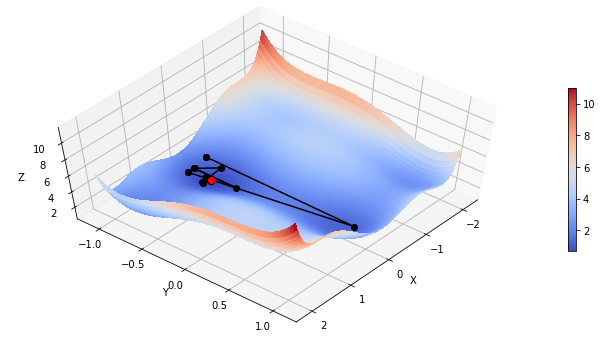

In [7]:
from pylab import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

def f(x1,x2):
    return 2 + (4.1 * x1**2) - (2.1 * x1**4) + (1/3 * x1**6) + (x1*x2) - (4 * (x2 - 0.05)**2) + (4 * x2**4)
xrange = np.linspace(-2.1, 2.1, 100)
yrange = np.linspace(-1.1, 1.1, 100)
X,Y = np.meshgrid(xrange, yrange)
Z = f(X, Y)
fig = plt.figure(figsize=(26,6))
# surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel('X', fontsize =10)
ax.set_ylabel('Y',fontsize =10)
ax.set_zlabel('Z',fontsize =10)
p=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist[:-1],ylist[:-1],maxlist[:-1], color="k", marker='o', zorder=10)
ax.plot3D([xlist[-1]],[ylist[-1]],[maxlist[-1]], color="r", marker='o', zorder=10)
ax.view_init(60, 40)

cb = fig.colorbar(p, shrink=0.5)

# 1.2

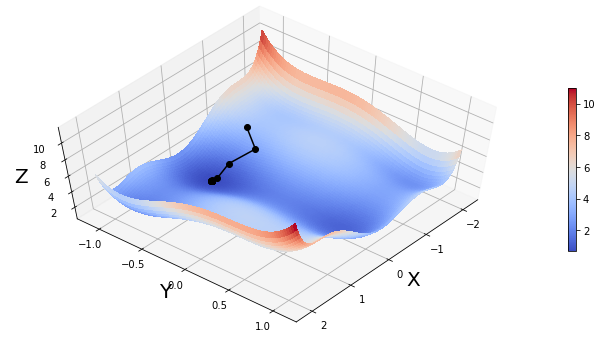

In [10]:
# Referenced from Week 1 material provided Dr. Frank Guerin
# Gradient Descent algorithm for minimisation problem
from pylab import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D
# Initial points
x1 , x2 = -1,-.8

# Optimisation function using two decision variables
def f(x1,x2):
    return (2 + (4.1 * x1**2) - (2.1 * x1**4) + (1/3 * x1**6) + (x1*x2) - (4 * (x2 - 0.05)**2) + (4 * x2**4))

# Lists to store x1, x2 and f values for the plot
xlist =[x1]
ylist =[x2]
zlist =[f(x1,x2)]

# Step size for the gradient descent algorithm
alpha = 0.1

# Calculating new values for x1, x2 and f using step size and gradient of the objective function
for step in range(50):
    x1 = x1 - alpha * (8.2*x1 - 8.4*x1**3 + 2*x1**5 + x2)
    xlist.append(x1)
    x2 = x2 - alpha * (x1 - 8*x2 + 0.4 + 16*x2**3)
    ylist.append(x2)
    zlist.append(f(x1,x2))
    
# print(x1,x2,f(x1,x2))
xrange = np.linspace(-2.1, 2.1, 100)
yrange = np.linspace(-1.1, 1.1, 100)
X,Y = np.meshgrid(xrange, yrange)
Z = f(X, Y)

fig = plt.figure(figsize=(26,6))

# surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel('X', fontsize =20)
ax.set_ylabel('Y',fontsize =20)
ax.set_zlabel('Z',fontsize =20)
p=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist,ylist,zlist, color="k", marker='o', zorder=10)
ax.view_init(60, 40)
cb = fig.colorbar(p, shrink=0.5)

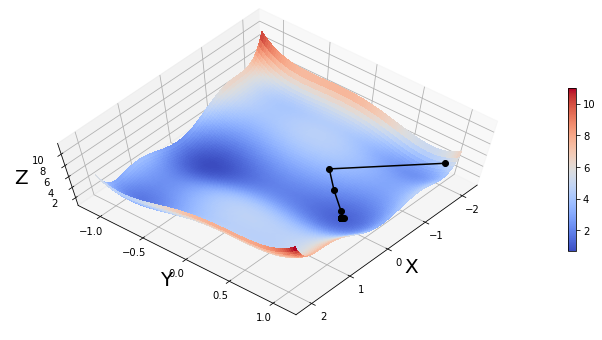

In [16]:
# Referenced from Week 1 material provided Dr. Frank Guerin
x1 , x2 = -2,1
def f(x1,x2):
    return (2 + (4.1 * x1**2) - (2.1 * x1**4) + (1/3 * x1**6) + (x1*x2) - (4 * (x2 - 0.05)**2) + (4 * x2**4))
xlist =[x1]
ylist =[x2]
zlist =[f(x1,x2)]
alpha = 0.1
for step in range(50):
    x1 = x1 - alpha * (8.2*x1 - 8.4*x1**3 + 2*x1**5 + x2)
    xlist.append(x1)
    x2 = x2 - alpha * (x1 - 8*x2 + 0.4 + 16*x2**3)
    ylist.append(x2)
    zlist.append(f(x1,x2))

xrange = np.linspace(-2.1, 2.1, 100)
yrange = np.linspace(-1.1, 1.1, 100)
X,Y = np.meshgrid(xrange, yrange)
Z = f(X, Y)

fig = plt.figure(figsize=(26,6))

# surface_plot with color grading and color bar
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel('X', fontsize =20)
ax.set_ylabel('Y',fontsize =20)
ax.set_zlabel('Z',fontsize =20)
p=ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, antialiased=False, zorder=0)
ax.plot3D(xlist,ylist,zlist, color="k", marker='o', zorder=10)
ax.view_init(70, 40)
cb = fig.colorbar(p, shrink=0.5)

# 2 a & b

fitness of the fittest individual  -1828.582920920748
Decoded value for x1 is  41.468619702188164


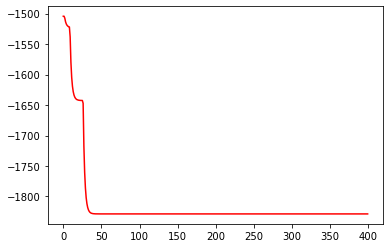

In [1]:
# Referenced from Week 3 material provided Dr. Frank Guerin
# Sample code for PSO, using DEAP library
import operator
import random
import numpy
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import numpy as np
import matplotlib.pyplot as plt

posMinInit      = -500
posMaxInit      = +500
VMaxInit        = 1.5
VMinInit        = 0.5
populationSize  = 50
dimension       = 20
interval        = 1
iterations      = 400 

#Parameter setup

wmax = 0.9 #weighting
wmin = 0.4 
c1   = 2.0
c2   = 2.0

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)
# particle rerpresented by list of 5 things
# 1. fitness of the particle, 
# 2. speed of the particle which is also going to be a list, 
# 3.4. limit of the speed value, 
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size)) 
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

# Objective function
def my_func(x):
    z = -np.sum(x * np.sin(np.sqrt(np.absolute(x))))
    return z,


def updateParticle(part, best, weight):
    #implementing speed = 0.7*(weight*speed + c1*r1*(localBestPos-currentPos) + c2*r2*(globalBestPos-currentPos))
    #Note that part and part.speed are both lists of size dimension
    #hence all multiplies need to apply across lists, so using e.g. map(operator.mul, ...

    r1 = (random.uniform(0, 1) for _ in range(len(part)))
    r2 = (random.uniform(0, 1) for _ in range(len(part)))

    v_r0 = [weight*x for x in part.speed]
    v_r1 = [c1*x for x in map(operator.mul, r1, map(operator.sub, part.best, part))] # local best
    v_r2 = [c2*x for x in map(operator.mul, r2, map(operator.sub, best, part))] # global best
    
    part.speed = [0.7*x for x in map(operator.add, v_r0, map(operator.add, v_r1, v_r2))]

#not using clamping
#     #clamp limits
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
            
    # update position with speed
    part[:] = list(map(operator.add, part, part.speed))

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)
toolbox.register("evaluate", my_func) #sphere function is built-in in DEAP

def main():
    # lists to store the fitness of the best individuals
    globalbest =[]
#     random.seed(102)
    pop = toolbox.population(n=populationSize) # Population Size
#     print(pop[1])
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    best = None

    #begin main loop
    for g in range(iterations):
        w = wmax # - (wmax-wmin)*g/iterations #decaying inertia weight
        
        for part in pop:
            part.fitness.values = toolbox.evaluate(part) #actually only one fitness value
            
            #update local best
            if (not part.best) or (part.best.fitness < part.fitness):   #lower fitness is better (minimising)
            #   best is None   or  current value is better              #< is overloaded        
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            
            #update global best
            if (not best) or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
#             globalbest.append(best.fitness.values[0])
                
        for part in pop:
            toolbox.update(part, best,w)
        
        globalbest.append(best.fitness.values[0])
        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
#             print(logbook.stream)
        
    print('fitness of the fittest individual ',best.fitness.values[0])
    print('Decoded value for x1 is ',best[0])
    plt.plot(np.array(globalbest),'r')
    return pop, logbook, best

if __name__ == "__main__":
    main()


# 2 c

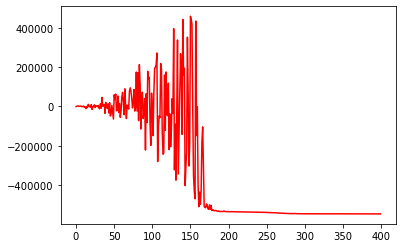

In [1]:
# Referenced from Week 3 material provided Dr. Frank Guerin
# Sample code for social learning PSO, using DEAP library
import operator
import random
import numpy
import numpy as np
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

posMinInit      = -500
posMaxInit      = +500
VMaxInit        = 1.5
VMinInit        = 0.5
dimension       = 20
interval        = 10
iterations      = 400#50*dimension
populationSize  = 100+int(dimension/10)

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre


# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

def my_func(x):
    z = -np.sum(x * np.sin(np.sqrt(np.absolute(x))))
    return z,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)
# particle rerpresented by list of 5 things
# 1. fitness of the particle, 
# 2. speed of the particle which is also going to be a list, 
# 3.4. limit of the speed value, 
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size)) 
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part



def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)
    
    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i 
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))
    
    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)
toolbox.register("evaluate", my_func) #sphere function is built-in in DEAP

def main():
    random.seed(101)
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields
    # List to store the fitness of the global best individual 
    best =[]
    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate(part) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best
        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)
        
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)
        
        # Appending the fitness of the global best individual
        best.append(part.fitness.values[0])
        
        # Gather all the fitnesses in one list and print the stats
        if g%interval==0: # interval
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
#             print(logbook.stream)
    plt.plot(np.array(best),'r')
    return pop, logbook

if __name__ == "__main__":
    main()


# 3.1

In [1]:
# Referenced from Week 4 material provided Dr. Frank Guerin

#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-4+8*numasint/2**10
    return numinrange

def calcFitness(individual):
    x1=individual[0:10]
    x2=individual[10:20]
    x3=individual[20:30]
    x1 = chrom2real(x1)
    x2 = chrom2real(x2)
    x3 = chrom2real(x3)
    f1=(((x1 - 0.6)/1.6)**2 + (x2/3.4)**2 + (x3-1.3)**2 ) / 2.0
    f2=(((x1/1.9) - 2.3)**2 + ((x2/3.3) - 7.1)**2 + (x3 + 4.3)**2)/3.0
    return f1,f2    
    
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 30)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxTwoPoint)
flipProb=1.0/30
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 0
    MU = 24
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
#     print(logbook.stream)

    return pop, logbook
f1_values =[]
f2_values =[]
output = []
from tabulate import tabulate
if __name__ == "__main__":
    pop, stats = main()
    
    front = numpy.array([ind.fitness.values for ind in pop])
    f1 = front[:,0]
    f2 = front[:,1]
    for i in pop:
        x1=i[0:10]
        x2=i[10:20]
        x3=i[20:30]
        x1 = chrom2real(x1)
        x2 = chrom2real(x2)
        x3 = chrom2real(x3)
        f1=(((x1 - 0.6)/1.6)**2 + (x2/3.4)**2 + (x3-1.3)**2 ) / 2.0
        f1_values.append(f1)
        f2=(((x1/1.9) - 2.3)**2 + ((x2/3.3) - 7.1)**2 + (x3 + 4.3)**2)/3.0
        f2_values.append(f2)
        output.append([x1,x2,x3,f1,f2])
    print(tabulate(output,headers = ['x1','x2','x3','f1','f2']))

        x1          x2          x3         f1       f2
----------  ----------  ----------  ---------  -------
-0.84375    -1.42188     1.3125      0.494635  31.9147
 3.875       3.53906    -1.53125     6.64457   14.6884
 1.58594     0.148438    0.257812    0.733888  24.2313
 1.25        3.29688    -2.15625     6.52548   14.8379
 1.46094     2.55469    -0.679688    2.38663   18.4891
 0.0078125   1.94531    -1.54688     4.28452   18.4125
-0.335938    3.5        -3.09375    10.3535    14.688
 0.8125      3.64844     0.226562    1.16069   19.9762
 3.57031     3.125      -2.83594    10.6986    13.3935
-1.35938    -1.52344     1.49219     0.868685  33.2737
 1.04688     3.10156     2.6875      1.41766   29.9438
 0.164062    1.35938    -1.02344     2.81622   20.1221
-0.460938    1.60156    -0.875       2.6961    20.6498
 2.82031    -2.00781     0.53125     1.4327    27.8087
 1.79688     0.90625    -0.21875     1.46861   21.6922
 2.70312    -2.71875     1.50781     1.20519   32.4293
-1.375     

# 3.2

       f1       f2    front number
---------  -------  --------------
 1.16069   19.9762               1
 0.733888  24.2313               1
 1.46861   21.6922               2
 1.4327    27.8087               2
 2.38663   18.4891               2
 1.53054   28.7335               3
 1.76552   23.5966               3
 1.41766   29.9438               3
 0.494635  31.9147               3
 2.6961    20.6498               3
 2.81622   20.1221               3
 4.28452   18.4125               3
 1.90874   31.0811               4
 2.49246   28.523                4
 1.20519   32.4293               4
 0.868685  33.2737               4
 6.17579   25.3908               4
 6.52548   14.8379               4
 6.64457   14.6884               4
10.6986    13.3935               4
10.3535    14.688                4
 4.22211   45.2386               5
 7.51313   28.5716               5
13.1606    19.9232               5
Worst objective values of f1 and f2 is 13.161 45.239


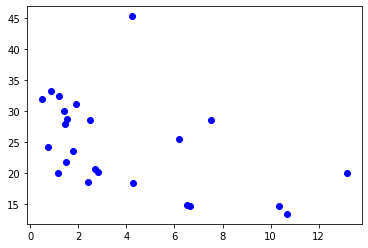

In [12]:

# Attempted code
def efficient_non_dominated_sorting(f1,f2):
    points =[]
    fronts =[]
    for i in range(len(f1)):
        points.append([f1[i],f2[i]])
    
    points.sort()
    
    for i in range(1,len(points)):
        points[i-1].append(i)
    
    fronts[0]=[]
    fronts[0].append(points[0])
    curentPoint = None
    lastFrontValue = None
    
    for i in range(1,len(points)):
        currentPoint= points[i]
        
        for j in range(len(fronts)):
            lastFrontValue = fronts[j][len(fronts[j])-1]
            
            if ( currentPoint[1]> lastFrontValue[1] and currentPoint[0] > lastFrontValue[0] and j == len(fronts-1)):
                fronts.append([])
                fronts[len(fronts)-1].append(currentPoint)
                
            if currentPoint[1] < lastFrontValue[1]:
                ifUnDominatedByAll = True
                
                x = fronts[j][len(fronts[j])-1]
                
                for k in range(x,0,-1):
                    if (currentPoint[1] > fronts[j][k][1] ):
                        ifUnDominatedByAll = False
                        break
                if(ifUnDominatedByAll):
                    fronts[j].append(currentPoint)
                    break
                else:
                    continue
    return fronts


# Referenced from Week 4 material provided Dr. Frank Guerin

from tabulate import tabulate

def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

front = fast_non_dominated_sort(f1_values[:],f2_values[:])
temp =[]

# Appending the values in temp to print as a table
for i in range(len(front)):
    for num in front[i]:
        temp.append([f1_values[num],f2_values[num],len(front)-i])
print(tabulate(temp[::-1], headers = ['f1', 'f2','front number']))
print('Worst objective values of f1 and f2 is',round(max(f1_values),3),round(max(f2_values),3))
plt.scatter(f1_values, f2_values, c="b")
plt.axis("tight")
plt.show()

# 3.3

In [11]:
# Referenced from Week 4 material provided Dr. Frank Guerin

import math
import random
from tabulate import tabulate

#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1
#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list
#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance
crowding_distance_values=[]
for i in range(0,len(front)):
    crowding_distance_values.append(crowding_distance(f1_values[:],f2_values[:],front[i][:]))
temp =[]
for i in range(len(front)):
    for num,cd in zip(front[i],crowding_distance_values[i]):
        temp.append([f1_values[num],f2_values[num],len(front)-i,cd])
print(tabulate(temp[::-1], headers = ['f1', 'f2','front number','crowding distance']))

       f1       f2    front number    crowding distance
---------  -------  --------------  -------------------
 1.16069   19.9762               1          4.44444e+15
 0.733888  24.2313               1          4.44444e+15
 1.46861   21.6922               2          4.44444e+15
 1.4327    27.8087               2         -2.54273
 2.38663   18.4891               2          4.44444e+15
 1.53054   28.7335               3          4.44444e+15
 1.76552   23.5966               3         -2.17883
 1.41766   29.9438               3         -2.33712
 0.494635  31.9147               3         -2.65609
 2.6961    20.6498               3         -2.80117
 2.81622   20.1221               3         -2.89242
 4.28452   18.4125               3          4.44444e+15
 1.90874   31.0811               4          4.44444e+15
 2.49246   28.523                4         -1.26374
 1.20519   32.4293               4         -1.21189
 0.868685  33.2737               4         -2.21744
 6.17579   25.3908          

# 3.4

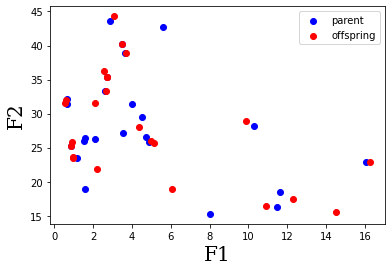

In [1]:
# Referenced from Week 4 material provided Dr. Frank Guerin

#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-4+8*numasint/2**10
    return numinrange

def calcFitness(individual):
    x1=individual[0:10]
    x2=individual[10:20]
    x3=individual[20:30]
    x1 = chrom2real(x1)
    x2 = chrom2real(x2)
    x3 = chrom2real(x3)
    f1=(((x1 - 0.6)/1.6)**2 + (x2/3.4)**2 + (x3-1.3)**2 ) / 2.0
    f2=(((x1/1.9) - 2.3)**2 + ((x2/3.3) - 7.1)**2 + (x3 + 4.3)**2)/3.0
    return f1,f2    
    
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 30)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxUniform , indpb = 0.9)
flipProb=1.0/30
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 1
    MU = 24
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
#     print(logbook.stream)

    # Begin the generational process
    for gen in range(NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        # selTournamentDCD means Tournament selection based on dominance (D) 
        # followed by crowding distance (CD). This selection requires the 
        # individuals to have a crowding_dist attribute
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #make pairs of all (even,odd) in offspring
            toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        record = stats.compile(offspring)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
#         print(logbook.stream)
    return pop, logbook,offspring
from tabulate import tabulate
if __name__ == "__main__":
    pop, stats , offspring = main()
    pop.sort(key=lambda x: x.fitness.values)
    front_pop = numpy.array([ind.fitness.values for ind in pop])
    offspring.sort(key=lambda x: x.fitness.values)
    front_off = numpy.array([ind.fitness.values for ind in offspring])
    parent = plt.scatter(front_pop[:,0], front_pop[:,1], c="b")
    offspring = plt.scatter(front_off[:,0], front_off[:,1], c="r")
    plt.legend((parent,offspring),('parent','offspring'),loc = 'upper right')
    font2 = {'family':'serif','color':'k','size':20}
    plt.xlabel('F1',fontdict = font2)
    plt.ylabel('F2',fontdict = font2)
    plt.axis("tight")
    plt.show()

# 3.5

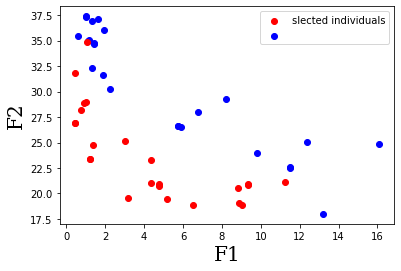

In [1]:
# Referenced from Week 4 material provided Dr. Frank Guerin

#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list

#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

toolbox = base.Toolbox()

def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-4+8*numasint/2**10
    return numinrange

def calcFitness(individual):
    # x1 in [1, 2,…, 16]; x2 in [1, 2,…, 8]; x3 in [1, 2, 3, 4]
    #        4 bits              3 bits             2 bits
    x1=individual[0:10]
    x2=individual[10:20]
    x3=individual[20:30]
#     x1= int(gray_to_bin("".join(str(i) for i in x1)),2)
#     x2= int(gray_to_bin("".join(str(i) for i in x2)),2)
#     x3= int(gray_to_bin("".join(str(i) for i in x3)),2)
    x1 = chrom2real(x1)
    x2 = chrom2real(x2)
    x3 = chrom2real(x3)
    f1=(((x1 - 0.6)/1.6)**2 + (x2/3.4)**2 + (x3-1.3)**2 ) / 2.0
    f2=(((x1/1.9) - 2.3)**2 + ((x2/3.3) - 7.1)**2 + (x3 + 4.3)**2)/3.0
    return f1,f2    
    
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 30)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxUniform , indpb = 0.9)
flipProb=1.0/30
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 1
    MU = 24
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
#     print(logbook.stream)

    # Begin the generational process
    for gen in range(NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        # selTournamentDCD means Tournament selection based on dominance (D) 
        # followed by crowding distance (CD). This selection requires the 
        # individuals to have a crowding_dist attribute
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #make pairs of all (even,odd) in offspring
            toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
#       Slecting the 24 individuals from the combined population
        pop = offspring + pop
        fitness = numpy.array([ind.fitness.values for ind in pop])
        f1 = fitness[:,0]
        f2 = fitness[:,1]
        front = fast_non_dominated_sort(f1,f2)
        f1_sorted =[]
        f2_sorted=[]
        for i in range(len(front)):
            for val in front[i]:
                f1_sorted.append(f1[val])
                f2_sorted.append(f2[val])
#         print(f1)
#         print(f1_sorted)

    return f1_sorted,f2_sorted
from tabulate import tabulate
if __name__ == "__main__":
    f1_sorted,f2_sorted = main()
#     pop.sort(key=lambda x: x.fitness.values)
#     front_pop = numpy.array([ind.fitness.values for ind in pop])
#     offspring.sort(key=lambda x: x.fitness.values)
#     front_off = numpy.array([ind.fitness.values for ind in offspring])
    old = plt.scatter(f1_sorted[:24], f2_sorted[:24], c="b")
    new = plt.scatter(f1_sorted[24:], f2_sorted[24:], c="r")
    plt.legend((new,old),('selected individuals',' '),loc = 'upper right')
    font2 = {'family':'serif','color':'k','size':20}
    plt.xlabel('F1',fontdict = font2)
    plt.ylabel('F2',fontdict = font2)
    plt.axis("tight")
    plt.show()
#     print(len(pop))
#     print(len(offspring))

C:\Users\mehul\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\mehul\anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


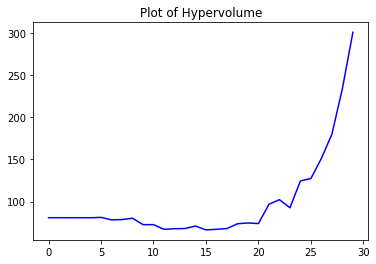

In [2]:
#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json

import numpy
import numpy as np

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list

#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

toolbox = base.Toolbox()

def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-4+8*numasint/2**10
    return numinrange

def calcFitness(individual):
    x1=individual[0:10]
    x2=individual[10:20]
    x3=individual[20:30]
    x1 = chrom2real(x1)
    x2 = chrom2real(x2)
    x3 = chrom2real(x3)
    f1=(((x1 - 0.6)/1.6)**2 + (x2/3.4)**2 + (x3-1.3)**2 ) / 2.0
    f2=(((x1/1.9) - 2.3)**2 + ((x2/3.3) - 7.1)**2 + (x3 + 4.3)**2)/3.0
    return f1,f2    
    
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 30)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxUniform , indpb = 0.9)
flipProb=1.0/30
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)
toolbox.register("select", tools.selNSGA2)

def main(seed=None):
    random.seed(seed)

    NGEN = 30
    MU = 24
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
#     print(logbook.stream)
    h_val =[]
    # Begin the generational process
    for gen in range(NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        # selTournamentDCD means Tournament selection based on dominance (D) 
        # followed by crowding distance (CD). This selection requires the 
        # individuals to have a crowding_dist attribute
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #make pairs of all (even,odd) in offspring
            toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop = offspring + pop
        fitness = numpy.array([ind.fitness.values for ind in pop])
#         print(fitness)
        f1 = fitness[:,0]
        f2 = fitness[:,1]
        front = fast_non_dominated_sort(f1,f2)
        f1_sorted =[]
        f2_sorted=[]
        pop_new =[]
#         print('0',front[0])
        for i in range(len(front)):
            for val in front[i]:
                f1_sorted.append(f1[val])
                f2_sorted.append(f2[val])
                pop_new.append(pop[val])
        pop = pop_new[:24]
        pop = toolbox.select(pop, len(pop))
#         print(pop,len(pop))
        h = hypervolume(pop,[14.65870, 46.9326])
        h_val.append(h)
#         record = stats.compile(offspring)
#         logbook.record(gen=gen, evals=len(invalid_ind), **record)
#         print(logbook.stream)
#         print("Final population hypervolume is %f" % hypervolume(pop, [14.65870, 46.9326]))
    
    return h_val[::-1]
from tabulate import tabulate
if __name__ == "__main__":
    h_val = main()
    plt.plot(np.array(h_val),'b')
    plt.title('Plot of Hypervolume')
    plt.show()